# Fatigue Detection Methods

## 1. Direct Method

This method is directly based on the result of facial landmarks dectection. Firstly, we calculate the EAR(Eye Aspected Ratio)for both eyes, if the value is smaller than 0.15, the eye can be considered as closed. Then we calculate the MAR(Mouth Aspected Ratio), if the value is bigger than 0.1, the mouth can be considered as yawn. If the eyes are closed and the mouth is open(yawn), we roughly judge it as fatigue.
Lastly, we evaluate the accuracy of this method on a test set. In this test set, there are three filefolders named as "Eyeclose", "Neutral" and "Yawn". We label the folders "Eyeclose" and "Yawn" as "Yes", which means fatigue, and the other folder as "No". These images in the test set are processed using the fatigue detection method described above, fatigue detection is given to each image and based on the results the results are compared with the actual labels and finally the accuracy of the whole process is calculated.

In [1]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Initialize dlib's face detector and face flag detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [3]:
# Calculate EAR and MAR
#if EAR <=0.15, eyeclosed; otherwise, false
#if MAR >=0.1, yawn; otherwise, false


def EAR_cpt(eye_LM):
    # Calculate the vertical distance
    v1 = np.linalg.norm(eye_LM[1] - eye_LM[5])
    v2 = np.linalg.norm(eye_LM[2] - eye_LM[4])
    vertical_dist = (v1 + v2) * 0.5
    
    # Calculated horizontal distance
    horizontal_dist = np.linalg.norm(eye_LM[0] - eye_LM[3])

    ear = vertical_dist / horizontal_dist

    return ear

def MAR_cpt(mouth_LM):
    # Calculate the vertical distance
    v_dist_top = np.linalg.norm(mouth_LM[13] - mouth_LM[19])  
    v_dist_bottom = np.linalg.norm(mouth_LM[14] - mouth_LM[18])  
    vertical_dist = (v_dist_top + v_dist_bottom) / 2.0

    # Calculated horizontal distance
    horizontal_dist = np.linalg.norm(mouth_LM[12] - mouth_LM[16])  

    mar = vertical_dist / horizontal_dist

    return mar

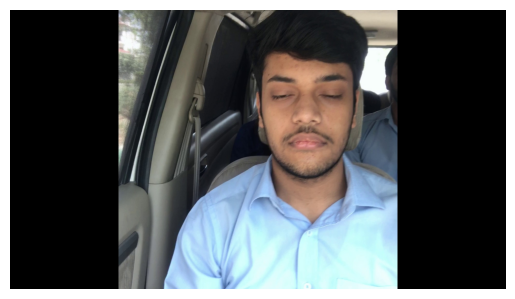

In [4]:
# Load the pictures
image_path = "361.jpg" 
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect the face
faces = detector(gray, 0)

# Store the EAR and MAR values for each face
ears = []
mars = []

# Use matplotlib to display images
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off') # Do not show axes
plt.show()

In [5]:
# Iterate over each face detected
for face in faces:
    shape = predictor(gray, face)
    shape_np = np.zeros((68, 2), dtype="int")
    for i in range(0, 68):
        shape_np[i] = (shape.part(i).x, shape.part(i).y)

    # Extract coordinates of eye and mouth 
    leftEye = shape_np[42:48]
    rightEye = shape_np[36:42]
    mouth = shape_np[48:68]

    # Calculate EAR and MAR
    leftEAR = EAR_cpt(leftEye)
    rightEAR = EAR_cpt(rightEye)
    ear = (leftEAR + rightEAR) / 2.0
    mar = MAR_cpt(mouth)
    
    # Store EAR and MAR values
    ears.append(ear)
    mars.append(mar)

    # Determine if fatigued
    drowsiness_detected = "Yes" if ear < 0.15 or mar > 0.1 else "No"
    print(f"Drowsiness Detected: {drowsiness_detected}, EAR: {ear:.4f}, MAR: {mar:.4f}")

Drowsiness Detected: Yes, EAR: 0.0927, MAR: 0.0041


In [6]:
# Prepare folders and labels
base_dir = "/Users/wangyaojie/Desktop/CV-3D-Project-main/code/test"  # path to the folder of "test"
folders = ["Eyeclose", "Neutral", "Yawn"]
labels = {"Eyeclose": "Yes", "Neutral": "No", "Yawn": "Yes"}

# Store labels and test results
true_labels = []
predicted_labels = []

In [7]:
# Iterate through each folder and picture
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            true_labels.append(labels[folder])
            
            # Reading and processing images
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray, 0)
            
            # Initialize fatigue detection as "No"
            drowsiness_detected = "No"
            for face in faces:
                shape = predictor(gray, face)
                shape_np = np.zeros((68, 2), dtype="int")
                for i in range(68):
                    shape_np[i] = (shape.part(i).x, shape.part(i).y)

                leftEye = shape_np[42:48]
                rightEye = shape_np[36:42]
                mouth = shape_np[48:68]

                ear = (EAR_cpt(leftEye) + EAR_cpt(rightEye)) / 2.0
                mar = MAR_cpt(mouth)

                if ear < 0.15 or mar > 0.1:
                    drowsiness_detected = "Yes"
                    break  
            
            predicted_labels.append(drowsiness_detected)

# Calculation accuracy of this method
accuracy = sum(1 for true, predicted in zip(true_labels, predicted_labels) if true == predicted) / len(true_labels)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9764
